# Spatial Segmentation and Key Drivers of Energy Consumption in the UK

*An analysis of consumer groups within the UK energy market and investigating socio-economic factors that influence the consumption patterns of different segments*

In [788]:
# load relevant packages for analysis
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from shapely.geometry import Point

## 1.0 Introduction

The purpose of this paper is to segment UK consumers based on energy usage and investigate factors which are highly correlated to high and low energy consumption. 

Following economic sanctions placed on Russian oil in 2022, energy prices in Europe increased dramatically. This led to public discontent and *knee-jerk* relief payments provided by the public sector. While these payments provided short-term relief, investigating the nature of energy consumption in UK and the factors contributing to it can inform more targetted policy which could make the UK more reslient against price shocks and highlight circumstances that contribute to high and low energy consumption.

This paper uses clustering to segment energy consumers at a postcode level and investigates these clusters using multivariable regression.

## 2.0 Literature Review

Developing targetted policy involves market segmentation, segment analysis, implementation and ongoing monitoring (Soto et al., 2021). This paper, due to its analytical nature, will investigate the first two steps.

Segmentation plays a crucial role in developing targeted policies by identifying distinct groups within a population. This enables the creation of finely tuned interventions that are more likely to be effective and meet the needs of different segments (Soto et al., 2021).

Clustering has emerged as a powerful tool to delineate target populations more effectively for policy implementation. Balashankar et al. (2022) illustrate how clustering methods can help segment populations and identify distinct groups crucial for developing effective and targeted policies.

There are many clustering strategies. The most popular of which are Hierarchal, DBSCAN and K-means. DBSCAN and hierarchical clustering are able to effectively handle geographic data with varying shapes and reveal multi-level hierarchical relationships among data points.

From here, targetted policy development investigates segments to ascertain their characteritics. Multivariable regression is frequently used to evaluate the influence of socio-economic and environmental factors on distinct population segments. This approach controls for multiple variables simultaneously, pinpointing the impacts of each factor. By applying this method, researchers can provide precise insights essential for targeted policy formulation. This tailored approach improves the effectiveness and fairness of interventions, addressing the unique needs of different consumer groups (Balashankar et al., 2022).

There are three fields the ONS commonly reports alongside energy consumption. 1. **Central Heating Type**  is crucial for understanding energy consumption as it directly influences the efficiency and amount of energy required to heat homes, making it a pivotal variable for targeted energy-saving interventions. 2. **Income Level** and 3. **Dwelling Type** are similarly important; they reflect the economic capacity to invest in energy-efficient solutions and the physical characteristics of a home that affect energy needs, which can guide the formulation of policies tailored to specific economic and housing conditions.

With this in mind, this paper investgates 2 research questions.

            RQ1 | Can we use spatial clustering to effectively segment the UK population based on electricity and gas consumption behaviour?
            RQ2 | How do central heating type, income level and dwelling type correlate with the energy consumption patterns of different consumer segments?

## 3.0 Methodology

This study will leverage open data from the *Office of National Statistics (ONS)* and energy consumption data from the *UK Department for Energy Security and Net Zero (DESNZ)*. All datasets are from the 2022. 

The energy consumption data provided by DESNZ is at the postcode level, while other fields are provided by Local Authority District (LAD). To overcome this issue we proceed with clustering at a postcode level, then determine which LADs these clusters geographically sit within. If clusters sit within 2 or more LADs, we simply aggregate the energy consumption data from these clusters for each LAD using a weighted average based on the number of postcodes from the cluster falling within each LAD. This method ensures that our analysis accurately reflects the geographical distribution of consumption data while aligning it with the socio-economic data at the LAD level.

As outlined above, this analysis will be conducted in two parts. First, consumer segmentation will done using unsupervised clustering. This will done purely based on variables geography and electricity and gas consumption for several reasons (Rehmatulla et al., 2017). 

Starting with geography and energy consumption keeps the analysis clear and focused, allowing for an understanding of core consumption patterns without the distraction of socio-economic factors. Słupik et al. suggests that this method establishes baseline segments that reflect the interaction between geographic characteristics and energy usage, providing a reference for further analysis (2021). Adopting this phased approach enhances methodological rigour, enabling systematic integration of additional variables and ensuring the analysis remains robust as complexity increases.

Each cluster will be categorised into 4 segments based on quartiles, 1. High, 2. Medium-High, 3. Medium-Low and 4. Low Consumption.

Unsupervised clustering is selected over supervised methods because it effectively identifies natural groupings within the data without prior labeling, crucial for discovering inherent patterns in energy consumption that are not predefined. 

Next, we will determine what characteristics are highly correlated with *High*, *Medium-High*, *Medium-Low* and *Low* energy consumption. Since this analysis aims to inform domestic policy, we select variables that are commonly assciated with previous domestic energy relief, these are income, central heating type and dwelling type. This correlation analysis will be based heavily on multiple linear regression. Given the goal of informing targeted domestic energy policies, multiple linear regression allows for the simultaneous examination of how various predictors influence energy consumption across different segments(Forootan et al., 2022). 

This method not only quantifies the strength of these relationships but also adjusts for the interdependencies among variables, providing a comprehensive and statistically robust basis for policy recommendations (Dou et al., 2023).

## 4.0 Data Overview, Processing & Exploration

This section reads in and processes the data for RQ1 and RQ2. Before moving into our analysis we provide an overview of the fields, explore the shape and distribution of our data and check for outliers and incosistencies which could lead to issues in this study. This will all be conducted in the following section after the cleaning phase of each dataset. 

The energy consumption from the DESNZ is provided at outcode level without geometry. The geopy library automatically finds and builds a geometry column based on outcode. DESNEZ provide mean, median and total electricity and gas consumption data by Kilowatt-hour (kWh). Below we drop both the *Mean* and *Total* consumption column and use *Median* annual electrity and gas consumption as it is least impacted by outliers. For this reason we do not normlise by population.

The [geopy](https://geopy.readthedocs.io/en/stable/) library can only assign one postcode per second and is computationally intensive. As a result, we only run this on the gas consumption data and join electricity data later.

As highlighted, the following is a computational intense process and was run when this analysis was originally conducted. The new CSV file is read in below the following four code chunks.

### 4.1 Read in Energy Consumption Data, Process and add Geometry

In [723]:
# read in desnez data
gas_df = pd.read_csv('data/gas_consumption.csv')
elec_df = pd.read_csv('data/electricity_consumption.csv')
outpop_df = pd.read_csv('data/outcode_population.csv') # pop. by outcode to normalise

In [725]:
# init geolocator
geolocator = Nominatim(user_agent="geoapiExercises")

# function to get lat / long
def get_lat_lon(outcode):
    try:
        location = geolocator.geocode(f"{outcode}, United Kingdom")
        return (location.latitude, location.longitude)
    except:
        return (None, None)

# avoid hitting rate limits
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# apply to outcode column
gas_df['Latitude_Longitude'] = gas_df['outcode'].apply(lambda x: get_lat_lon(x))

gas_df.to_csv('data/gas_df.csv', index=False)

In [742]:
gas_df = pd.read_csv('data/gas_df.csv')

In [744]:
gas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2410 entries, 0 to 2409
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   outcode              2410 non-null   object 
 1   gas_total_cons_kwh   2410 non-null   float64
 2   gas_mean_cons_kwh    2410 non-null   float64
 3   gas_median_cons_kwh  2410 non-null   float64
 4   Latitude_Longitude   2410 non-null   object 
dtypes: float64(3), object(2)
memory usage: 94.3+ KB


In [746]:
# convert string coordinates to a point object
def parse_coordinates(coord_str):
    if coord_str == "None, None":
        return None
    try:
        lat, lon = coord_str.strip('()').split(',')
        return Point(float(lon.strip()), float(lat.strip()))
    except (ValueError, TypeError):
        return None

# Apply to 'Latitude_Longitude'
gas_df['geometry'] = gas_df['Latitude_Longitude'].apply(parse_coordinates)

# Remove 'None' rows
gas_df = gas_df[gas_df['geometry'].notna()]

# DataFrame to GeoDataFrame
gas_gdf = gpd.GeoDataFrame(gas_df, geometry='geometry')

# Set WGS 84 CRS
gas_gdf.set_crs(epsg=4326, inplace=True)

# Join electricity consumption data by outcode
energycon_gdf = pd.merge(gas_gdf, elec_df, on='outcode', how='inner')

# Drop total & mean consumption columns
columns_to_drop = ['gas_total_cons_kwh', 'gas_mean_cons_kwh', 'elec_total_cons_kwh', 'elec_mean_cons_kwh', 'Latitude_Longitude']
energycon_gdf = energycon_gdf.drop(columns=columns_to_drop)

In [748]:
# normalise our energy consumption data by outcode population 
# perform inner join
energycon_gdf = pd.merge(
    energycon_gdf,
    outpop_df[['Postcode Districts', 'Count']],
    left_on='outcode',
    right_on='Postcode Districts',
    how='inner'
)

# normalise x population count
energycon_gdf['n_gas_median_cons_kwh'] = energycon_gdf['gas_median_cons_kwh'] / energycon_gdf['Count']
energycon_gdf['n_elec_median_cons_kwh'] = energycon_gdf['elec_median_cons_kwh'] / energycon_gdf['Count']

# drop 'Postcode Districts'
energycon_gdf.drop(columns=['Postcode Districts'], inplace=True)

# calc mean and standard deviation
mean_values = energycon_gdf[['n_gas_median_cons_kwh', 'n_elec_median_cons_kwh']].mean()
std_dev = energycon_gdf[['n_gas_median_cons_kwh', 'n_elec_median_cons_kwh']].std()

# detect and remove outliers more than 2 StD. from the mean
is_outlier = ((energycon_gdf[['n_gas_median_cons_kwh', 'n_elec_median_cons_kwh']] < (mean_values - 2 * std_dev)) |
              (energycon_gdf[['n_gas_median_cons_kwh', 'n_elec_median_cons_kwh']] > (mean_values + 2 * std_dev))).any(axis=1)
energycon_gdf = energycon_gdf[~is_outlier]

# save
energycon_gdf.to_file('energycon.gpkg', driver='GPKG')

In [750]:
# read in processed 'energy consumption data' & check
energycon_gdf = gpd.read_file('energycon.gpkg')
energycon_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1429 entries, 0 to 1428
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   outcode                 1429 non-null   object  
 1   gas_median_cons_kwh     1429 non-null   float64 
 2   elec_median_cons_kwh    1429 non-null   float64 
 3   Count                   1429 non-null   int64   
 4   n_gas_median_cons_kwh   1429 non-null   float64 
 5   n_elec_median_cons_kwh  1429 non-null   float64 
 6   geometry                1429 non-null   geometry
dtypes: float64(4), geometry(1), int64(1), object(1)
memory usage: 78.3+ KB


In [752]:
numeric_cols = energycon_gdf.select_dtypes(include=[np.number])

# descriptive stats
basic_stats = numeric_cols.describe()

# count of non-null entries
nonnull_counts = energycon_gdf.count()

# data types
data_types = energycon_gdf.dtypes

# quantiles
quantiles = numeric_cols.quantile([0.25, 0.5, 0.75])

# correlation matrix
correlation_matrix = numeric_cols.corr()

# display
print("Descriptive Statistics:\n", basic_stats)
print("\nCount of Non-Null Entries:\n", nonnull_counts)
print("\nData Types:\n", data_types)
print("\nQuantiles:\n", quantiles)
print("\nCorrelation Matrix:\n", correlation_matrix)

Descriptive Statistics:
        gas_median_cons_kwh  elec_median_cons_kwh          Count  \
count          1429.000000           1429.000000    1429.000000   
mean          10095.291839           2611.974050   27664.167950   
std            1998.934236            352.451779   17787.980163   
min            3728.318537           1577.100000      55.000000   
25%            8926.833145           2392.400000   14852.000000   
50%            9815.550000           2542.000000   25310.000000   
75%           10889.086886           2772.200000   36906.000000   
max           28575.457630           5444.500000  170304.000000   

       n_gas_median_cons_kwh  n_elec_median_cons_kwh  
count            1429.000000             1429.000000  
mean                1.340411                0.339435  
std                 8.360627                2.049145  
min                 0.059852                0.014346  
25%                 0.256299                0.066603  
50%                 0.386284             

#### Given the following summary statistics we can infer the following conclusions about our data:
- **Consumption Variability:** The dataset from 1,429 outcodes shows a median gas consumption range of 3,728 to 28,575 kWh, with electricity consumption being less variable, ranging from 1,577 to 5,444 kWh. Median gas consumption typically around 9,815 kWh reflects substantial regional differences.
- **Correlation and Efficiency:** There's a moderate correlation (about 0.46) between gas and electricity consumption, suggesting that higher gas usage often aligns with higher electricity usage. Normalised consumption values reveal efficiencies of about 1.34 kWh for gas and 0.34 kWh for electricity per unit count, with some regions showing exceptionally high usage.
- **Statistical Overview:** The dataset exhibits a broad count range from 55 to 170,304, suggesting diverse outcode sizes. All key columns are fully populated, ensuring comprehensive data analysis. The strong correlation (0.977) between normalised gas and electricity values underscores consistent regional energy usage patterns.

Below, we read and process the socio-economic data for the clustering and segmentation analysis. There are five fields taken from four datasets recorded by LAD. The population, dwelling type, central heating type and income data all comes from the ONS. This data is merged with LAD polygon data, also provided by the ONS. 

The socio-economic data is provided as raw counts, thus, we conduct per capita normalisation to ensure our analysis is accurate. During the normalisation process we deal with NaN and 0 values.

### 4.2 Read in Socio-Economic Data, Process and add Geometry column

In [79]:
# read in ONS socioeconomic & LAD geometry data
income = pd.read_csv('data/annual_income.csv') # annual income
heat_type = pd.read_csv('data/heating_type.csv') # central heating type
dw_type = pd.read_csv('data/accomodation_type.csv') # dwelling type
lad = gpd.read_file("data/Local_Authority_Districts/LAD_MAY_2022_UK_BFE_V3.shp") # lad polygon data
pop = pd.read_excel("data/population.xlsx") # pop

In [80]:
# process and clean income data
median_income = income.groupby('Local authority code')['Total annual income (£)'].median().reset_index()

# rename 'med average annual income' & print
median_income.rename(columns={'Total annual income (£)': 'Med average annual income (£)'}, inplace=True)
median_income.rename(columns={'Local authority code': 'Lower tier local authorities Code'}, inplace=True)
median_income.head(2)

,Lower tier local authorities Code,Med average annual income (£)
0,E06000001,31050.0
1,E06000002,35500.0


In [83]:
# process heating & dwelling type data
# pivot heating type
heatpivot_df = heat_type.pivot(
    index='Lower tier local authorities Code',
    columns='Type of central heating in household (5 categories)',
    values='Observation'
)

# 'LAD Code' as index
heatpivot_df.reset_index(inplace=True)

# pivot 'dw type'
dwpivot_df = dw_type.pivot(index='Lower tier local authorities Code', 
                         columns='Accommodation type (5 categories)', 
                         values='Observation')

# 'LAD Code' as index
dwpivot_df.reset_index(inplace=True)

In [84]:
# merge 'dwpivot_df' and 'heatpivot_df' on 'Lower tier local authorities Code'
merged_df = pd.merge(dwpivot_df, heatpivot_df, on='Lower tier local authorities Code', how='outer')

# merge with 'income' on 'Lower tier local authorities Code'
socec_df = pd.merge(merged_df, median_income, on='Lower tier local authorities Code', how='outer')

# display
socec_df.head(2)

,Lower tier local authorities Code,A caravan or other mobile or temporary structure,"Flat, maisonette or apartment",Whole house or bungalow: Detached,Whole house or bungalow: Semi-detached,Whole house or bungalow: Terraced,Does not apply,Does not have central heating,Has one type of central heating,Two or more types of central heating (including renewable energy),Two or more types of central heating (not including renewable energy),Med average annual income (£)
0,E06000001,115.0,4725.0,8086.0,14537.0,13469.0,0.0,342.0,36686.0,180.0,3722.0,31050.0
1,E06000002,51.0,7569.0,10389.0,25485.0,16768.0,0.0,752.0,53648.0,178.0,5684.0,35500.0


In [85]:
# merge 'LAD' and 'socec_df' geographic data
lad_filtered = lad[['LAD22CD', 'geometry']]

# keep all 'socec_df' columns and only 'geometry' from 'lad'
socec_df = pd.merge(socec_df, lad_filtered, how='left', left_on='Lower tier local authorities Code', right_on='LAD22CD')

# drop 'LAD22CD' & display
socec_df.drop(columns=['LAD22CD'], inplace=True)

In [86]:
# final cleaning
# drop
socec_df.drop(columns=['Does not apply'], inplace=True)

# rename index as 'LAD'
socec_df.rename(columns={'Lower tier local authorities Code': 'LAD'}, inplace=True)

# geometry as last column
geometry = socec_df.pop('geometry')
socec_df['geometry'] = geometry

# rename
column_rename_map = {
    'A caravan or other mobile or temporary structure': 'dwelling_type: mobile',
    'Flat, maisonette or apartment': 'dwelling_type: flat',
    'Whole house or bungalow: Detached': 'dwelling_type: detached house',
    'Whole house or bungalow: Semi-detached': 'dwelling_type: semi-detached',
    'Whole house or bungalow: Terraced': 'dwelling_type: terraced',
    'Does not have central heating': 'no central heating',
    'Has one type of central heating': '1 central heating',
    'Two or more types of central heating (including renewable energy)': '2+ central heating (renewable)',
    'Two or more types of central heating (not including renewable energy)': '2+ central heating (non-renewable)',
    'Med average annual income (£)': 'mean annual income'
}
socec_df.rename(columns=column_rename_map, inplace=True)

# print
socec_df.head(2)

,LAD,dwelling_type: mobile,dwelling_type: flat,dwelling_type: detached house,dwelling_type: semi-detached,dwelling_type: terraced,no central heating,1 central heating,2+ central heating (renewable),2+ central heating (non-renewable),mean annual income,geometry
0,E06000001,115.0,4725.0,8086.0,14537.0,13469.0,342.0,36686.0,180.0,3722.0,31050.0,"POLYGON ((447213.900 537036.104, 447228.798 53..."
1,E06000002,51.0,7569.0,10389.0,25485.0,16768.0,752.0,53648.0,178.0,5684.0,35500.0,"POLYGON ((448489.897 522071.798, 448592.597 52..."


In [87]:
# normalise these values by the population of each LAD 
# start by adding population to df:
# left join data using 'socec_df' as master
pop_filtered = pop[['Code', 'All ages']]
socec_df = pd.merge(socec_df, pop_filtered, how='left', left_on='LAD', right_on='Code')

# rename 'All ages' column to 'population' and drop redundant 'Code' column
socec_df.rename(columns={'All ages': 'population'}, inplace=True)
socec_df.drop(columns=['Code'], inplace=True)

In [88]:
# normalise all the necessary fields
# columns to normalise
columns_to_normalise = [
    'dwelling_type: mobile', 'dwelling_type: flat', 'dwelling_type: detached house',
    'dwelling_type: semi-detached', 'dwelling_type: terraced',
    'no central heating', '1 central heating',
    '2+ central heating (renewable)', '2+ central heating (non-renewable)'
]

# remove rows where pop is NaN / 0
cleaned_df = socec_df[socec_df['population'].notna() & (socec_df['population'] > 0)]

# new df for normalised data
nsocec_df = cleaned_df[['LAD', 'geometry', 'mean annual income']].copy()

# normalise each column by population & display
for column in columns_to_normalise:
    nsocec_df[column] = cleaned_df[column] / cleaned_df['population']
nsocec_df.head(2)

,LAD,geometry,mean annual income,dwelling_type: mobile,dwelling_type: flat,dwelling_type: detached house,dwelling_type: semi-detached,dwelling_type: terraced,no central heating,1 central heating,2+ central heating (renewable),2+ central heating (non-renewable)
0,E06000001,"POLYGON ((447213.900 537036.104, 447228.798 53...",31050.0,0.001225,0.050340,0.086149,0.154878,0.143499,0.003644,0.390855,0.001918,0.039654
1,E06000002,"POLYGON ((448489.897 522071.798, 448592.597 52...",35500.0,0.000344,0.051044,0.070061,0.171865,0.113080,0.005071,0.361790,0.001200,0.038332


In [89]:
# convert to gdf using epsg:4326
nsocec_gdf = gpd.GeoDataFrame(nsocec_df, geometry='geometry')
nsocec_gdf.set_crs("epsg:4326", inplace=True, allow_override=True)
nsocec_gdf.head(2)

,LAD,geometry,mean annual income,dwelling_type: mobile,dwelling_type: flat,dwelling_type: detached house,dwelling_type: semi-detached,dwelling_type: terraced,no central heating,1 central heating,2+ central heating (renewable),2+ central heating (non-renewable)
0,E06000001,"POLYGON ((447213.89950 537036.10450, 447228.79...",31050.0,0.001225,0.050340,0.086149,0.154878,0.143499,0.003644,0.390855,0.001918,0.039654
1,E06000002,"POLYGON ((448489.89690 522071.79790, 448592.59...",35500.0,0.000344,0.051044,0.070061,0.171865,0.113080,0.005071,0.361790,0.001200,0.038332


The socioeconomic data is merged and formatted. Below we produce the summary statistics for each field.

In [91]:
# summary statistics for numeric fields
numeric_stats = nsocec_gdf.describe()

# statistics for 'geometry'
if 'geometry' in nsocec_gdf.columns:
    geometry_types = nsocec_gdf['geometry'].geom_type.value_counts()

# numeric statistics
print("Numeric Fields Summary Statistics:\n", numeric_stats)

# print the geometry statistics
if 'geometry' in nsocec_gdf.columns:
    print("\nGeometry Types:\n", geometry_types)

Numeric Fields Summary Statistics:
        mean annual income  dwelling_type: mobile  dwelling_type: flat  \
count          301.000000             314.000000           314.000000   
mean         46630.232558               0.002067             0.082017   
std           9870.109740               0.002098             0.065401   
min          31050.000000               0.000000             0.017910   
25%          39000.000000               0.000503             0.044090   
50%          44600.000000               0.001333             0.063788   
75%          53350.000000               0.002957             0.094242   
max         101800.000000               0.013217             0.443809   

       dwelling_type: detached house  dwelling_type: semi-detached  \
count                     314.000000                    314.000000   
mean                        0.108347                      0.130504   
std                         0.055624                      0.037655   
min                       

The average mean annual income across the 301 entries is approximately £46,630, but the range is quite broad, with a maximum income reported as £101,800. The normalised dwelling data reveals a predominance of flats and semi-detached houses, with relatively minor variations in central heating systems, suggesting a general uniformity in dwelling types and heating across the sampled regions.

The presence of missing data in 'mean annual income' alongside its lack of normalisation may skew comparative analyses, especially when compared to other per capita normalised metrics. The mix of Polygon and MultiPolygon geometries in the dataset necessitates careful handling to ensure accuracy in spatial operations and consistency in geographic analyses.

In [220]:
# address missing data in 'mean annual income'
print(f"Missing data in 'mean annual income' before cleanup: {nsocec_df['mean annual income'].isna().sum()}")
nsocec_df['mean annual income'].fillna(nsocec_df['mean annual income'].median(), inplace=True)
print(f"After imputing missing values with median: {nsocec_df['mean annual income'].isna().sum()}")

# ensure geometry consistency
nsocec_df['geometry'] = nsocec_df['geometry'].apply(lambda x: x if x.is_valid else x.buffer(0))
nsocec_df = nsocec_df.explode('geometry')

# correct data type inconsistencies
nsocec_df['mean annual income'] = pd.to_numeric(nsocec_df['mean annual income'], errors='coerce')

# status report
print("\nData Types in DataFrame:")
nsocec_df.dtypes

Missing data in 'mean annual income' before cleanup: 0
After imputing missing values with median: 0

Final Data Types in DataFrame:


LAD                                    object
geometry                               object
mean annual income                    float64
dwelling_type: mobile                 float64
dwelling_type: flat                   float64
dwelling_type: detached house         float64
dwelling_type: semi-detached          float64
dwelling_type: terraced               float64
no central heating                    float64
1 central heating                     float64
2+ central heating (renewable)        float64
2+ central heating (non-renewable)    float64
dtype: object

## 5.0 Analysis

After cleaning and conducting an inner join on the energy consumption data, there are 1429 data points remaining. We now proceed with the analysis. First, this entails segmentation and secondly a socioeconomic analysis of those consumers segments.

### 5.1 Segmentation of UK Energy Consumers: Unsupervised Clustering

Below, we leverage unsupervised spatial clustering to group consumers based on energy consumption and geography. These groups will then be categorised into four segments we will use in the second part of our analysis. These segments are:
- High: Top 25% of consumption
- Medium-High: 50-75% of consumption
- Medium-Low: 25-50% of consumption
- Low: Bottom 25% of consumption

In our study of UK energy consumption, we applied the K-Means clustering algorithm to segment consumers based on usage and location. The optimal number of clusters was determined using the Elbow Method, which identifies the point where the increase in clusters ceases to significantly reduce the within-cluster sum of squares. This approach helps in choosing an appropriate cluster count that maximises both cluster compactness and separation.

The effectiveness of the clusters was evaluated using the Silhouette Score, a measure of how well-separated the clusters are relative to their proximity. High Silhouette Scores indicate well-defined clusters, supporting the robustness of our clustering approach, which is crucial for informed energy policy development.

In [792]:
# read in spatial consumption data
gdf = gpd.read_file('energycon.gpkg')

In [796]:
#init. values for the spatial clustering
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y

# prep data for clustering
X = gdf[['n_gas_median_cons_kwh', 'n_elec_median_cons_kwh', 'x', 'y']]

# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

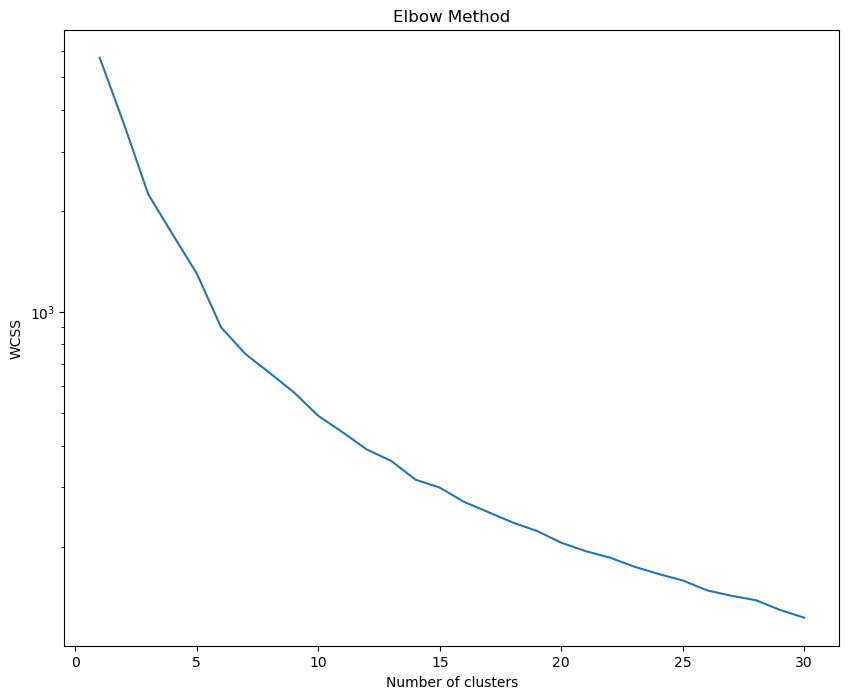

In [798]:
# elbow analysis
wcss = []
for i in range(1, 31):  # Testing cluster numbers from 1 to 30
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=20, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the WCSS values
plt.figure(figsize=(10, 8))
plt.plot(range(1, 31), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.yscale('log')
plt.show()

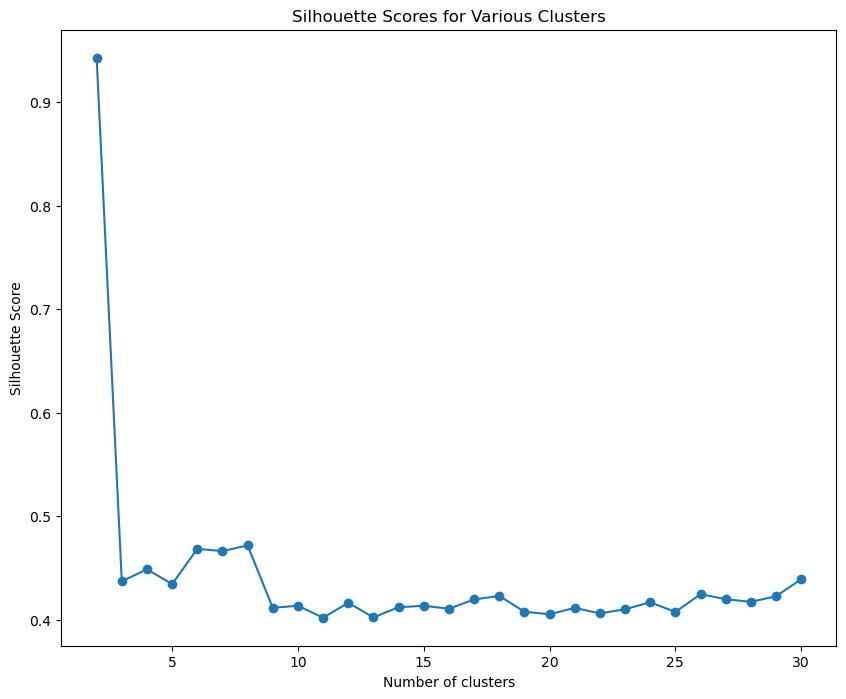

In [800]:
# Silhouette scores to evaluate the quality of clusters formed
silhouette_scores = []
for i in range(2, 31):  # Cannot compute silhouette score with only one cluster
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=20, random_state=0)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Plotting the Silhouette scores
plt.figure(figsize=(10, 8))
plt.plot(range(2, 31), silhouette_scores, marker='o')
plt.title('Silhouette Scores for Various Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

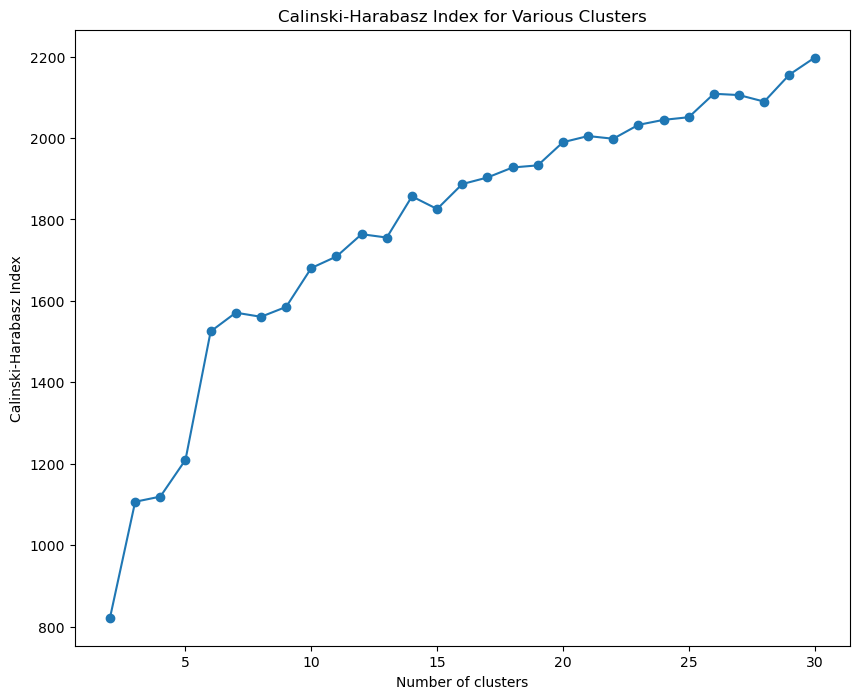

In [802]:
# Calinski-Harabasz Index to evaluate the clusters
calinski_harabasz_scores = []
for i in range(2, 31):  # Cannot compute with only one cluster
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=20, random_state=0)
    labels = kmeans.fit_predict(X_scaled)
    score = calinski_harabasz_score(X_scaled, labels)
    calinski_harabasz_scores.append(score)

# Plotting the Calinski-Harabasz Index
plt.figure(figsize=(10, 8))
plt.plot(range(2, 31), calinski_harabasz_scores, marker='o')
plt.title('Calinski-Harabasz Index for Various Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.show()

The Elbow Method suggests a more gradual WCSS decrease from 10 clusters, while the Silhouette Score plateaus after 5, indicating stable cluster definition. The Calinski-Harabasz Index increases with more clusters and shows no clear plateau. Between 7 -10 the gradient becomes more stable. Combining these insights, starting with 10 clusters would balance distinctness and model complexity, aligning with the goal of identifying meaningful UK energy consumption segments.

/Users/nikhildesai/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


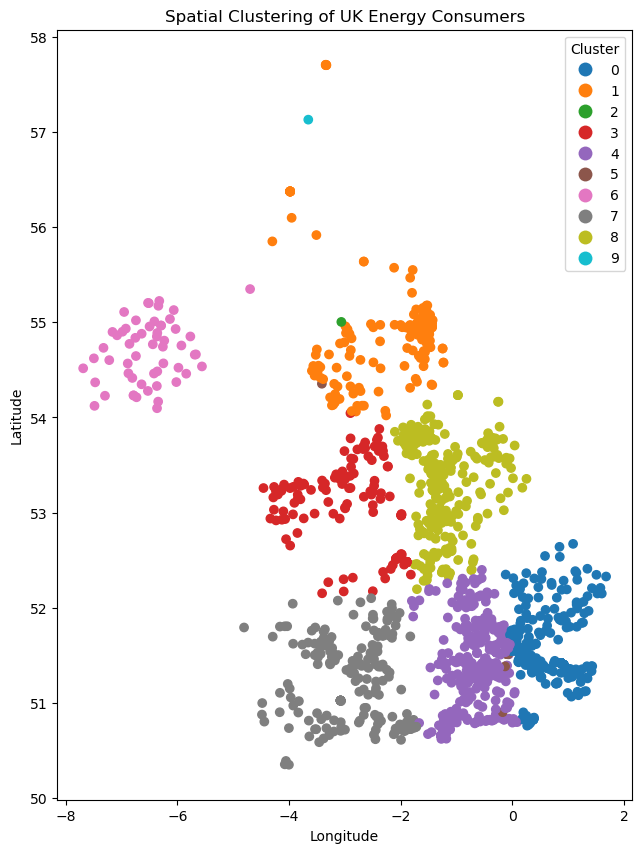

In [817]:
# Choose the optimal number from the elbow analysis, let's assume it's 10 for this example
optimal_clusters = 10
kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(X_scaled)

# Assign cluster labels to the original dataframe
gdf['cluster'] = cluster_labels

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(column='cluster', ax=ax, categorical=True, legend=True, legend_kwds={'title': "Cluster"})

plt.title('Spatial Clustering of UK Energy Consumers')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [819]:
# calc total energy consumption
gdf['total_energy'] = gdf['n_gas_median_cons_kwh'] + gdf['n_elec_median_cons_kwh']

# define segments by quartiles
gdf['consumption_segment'] = pd.qcut(gdf['total_energy'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

# ensure that energy consumption values are numeric
gdf['n_gas_median_cons_kwh'] = pd.to_numeric(gdf['n_gas_median_cons_kwh'], errors='coerce')
gdf['n_elec_median_cons_kwh'] = pd.to_numeric(gdf['n_elec_median_cons_kwh'], errors='coerce')
gdf['total_energy'] = gdf['n_gas_median_cons_kwh'] + gdf['n_elec_median_cons_kwh']

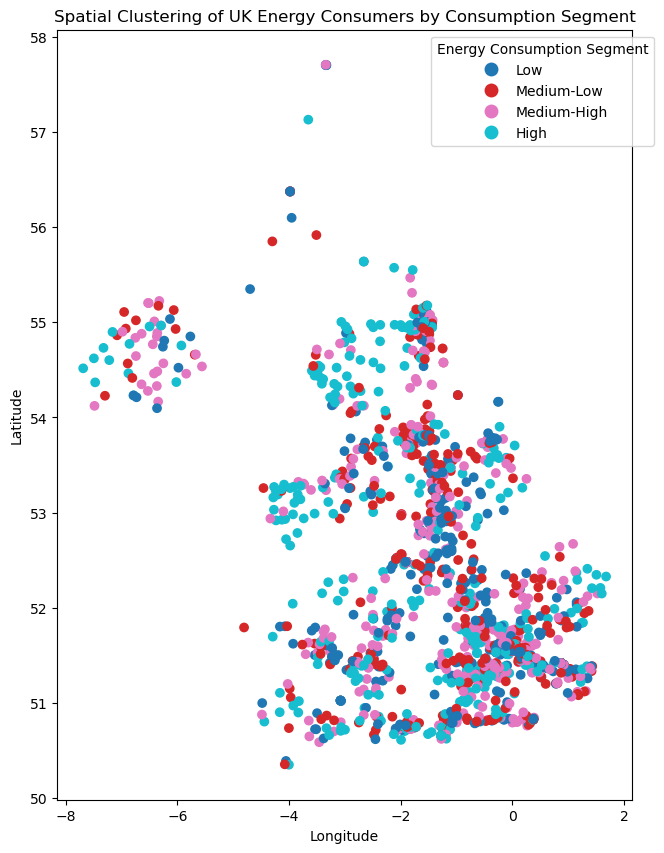

In [821]:
# NaN values from conversion errors are handled
gdf.dropna(subset=['total_energy'], inplace=True)

# Calculate mean energy consumption for each segment
mean_consumption = gdf.groupby('consumption_segment')['total_energy'].mean().reset_index()

# Visualization
if not isinstance(gdf, gpd.GeoDataFrame):
    gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf.x, gdf.y))

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(column='consumption_segment', ax=ax, legend=True)

# Configure the legend
leg = ax.get_legend()
leg.set_title("Energy Consumption Segment")
leg.set_bbox_to_anchor((1.05, 1))  # Adjust legend position outside of plot

plt.title('Spatial Clustering of UK Energy Consumers by Consumption Segment')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#### 5.2 Factors Contributing to Segment Energy Consumption: Multilogistic Regression Analysis

In [ ]:
# load cleaned & normalised data as 'gdf'
gdf = gpd.read_file('normalised_energyconsumption_df.gpkg')
# check
gdf.head()

### 6.0 Discussion

#### References

Balashankar, A. et al. (2022) ‘Targeted policy recommendations using outcome-aware clustering’, ACM SIGCAS/SIGCHI Conference on Computing and Sustainable Societies (COMPASS). doi:10.1145/3530190.3534797. 

Dou, Y., Tan, S. and Xie, D. (2023) ‘Comparison of machine learning and statistical methods in the field of Renewable Energy Power Generation Forecasting: A mini review’, Frontiers in Energy Research, 11. doi:10.3389/fenrg.2023.1218603. 

Forootan, M.M. et al. (2022) ‘Machine learning and deep learning in energy systems: A Review’, Sustainability, 14(8), p. 4832. doi:10.3390/su14084832. 

Rehmatulla, N., Calleya, J. and Smith, T. (2017) ‘The implementation of technical energy efficiency and CO 2 emission reduction measures in shipping’, Ocean Engineering, 139, pp. 184–197. doi:10.1016/j.oceaneng.2017.04.029. 

Słupik, S., Kos-Łabędowicz, J. and Trzęsiok, J., 2021. An innovative approach to energy consumer segmentation—a behavioural perspective. the case of the eco-bot project. Energies, 14(12), p.3556.
